# Benchmark Quality Notebook

Replica esatta di logic `scripts/benchmark_quality.py`.

In [33]:
import sys
import asyncio
import json
import httpx
import warnings
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score
)
# Fallback se ipywidgets manca: usa tqdm normale invece di tqdm.notebook
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")

# === CONFIGURAZIONE ===
URL = "http://localhost:8080"
BASE_DIR = Path("..")
TEST_DIR_AI = BASE_DIR / "src/data/Test/ai"
TEST_DIR_NON_AI = BASE_DIR / "src/data/Test/non_ai"
BATCH_SIZE = 10

In [34]:
async def classify_batch(client: httpx.AsyncClient, url: str, texts: list[str]) -> list[dict]:
    try:
        response = await client.post(f"{url}/classify", json={"texts": texts})
        response.raise_for_status()
        return response.json()["predictions"]
    except Exception as e:
        print(f"Request failed: {e}")
        return []

async def run_benchmark(test_dir_ai: Path, test_dir_non_ai: Path, url: str, batch_size: int = 10):
    # 1. Load Data
    samples = []
    
    # Load AI samples
    print(f"Loading AI samples from {test_dir_ai}...")
    ai_files = list(test_dir_ai.glob("*.txt"))
    for p in ai_files:
        try:
            text = p.read_text(encoding="utf-8").strip()
            if text:
                samples.append({"text": text, "true_label": 1, "filename": p.name}) # 1 = AI
        except Exception as e:
            print(f"Could not read {p}: {e}")

    # Load Non-AI samples
    print(f"Loading Non-AI samples from {test_dir_non_ai}...")
    non_ai_files = list(test_dir_non_ai.glob("*.txt"))
    for p in non_ai_files:
        try:
            text = p.read_text(encoding="utf-8").strip()
            if text:
                samples.append({"text": text, "true_label": 0, "filename": p.name}) # 0 = Non-AI
        except Exception as e:
            print(f"Could not read {p}: {e}")
            
    if not samples:
        print("No samples found!")
        return None
        
    print(f"Total samples: {len(samples)} (AI: {len(ai_files)}, Non-AI: {len(non_ai_files)})")

    # 2. Run Inference
    y_true = []
    y_pred = []
    y_scores = [] 
    
    async with httpx.AsyncClient(timeout=30.0) as client:
        # Check health
        try:
            resp = await client.get(f"{url}/health")
            resp.raise_for_status()
            print(f"Service status: {resp.json().get('status')}")
        except Exception as e:
            print(f"Service check failed at {url}: {e}")
            print("Is the inference service running? (docker compose up ...)")
            return None

        # Process in batches
        all_texts = [s["text"] for s in samples]
        chunks = [all_texts[i:i + batch_size] for i in range(0, len(all_texts), batch_size)]
        
        results = []
        # Usa tqdm standard se notebook fallisce
        for chunk in tqdm(chunks, desc="Classifying"):
            batch_predictions = await classify_batch(client, url, chunk)
            if not batch_predictions:
                print("Failed to get predictions for a batch. Skipping...")
                for _ in chunk:
                    results.append({"label": "NON_AI", "confidence": 0.0})
            else:
                results.extend(batch_predictions)
    
    # 3. Process Results
    for i, sample in enumerate(samples):
        if i >= len(results):
            break
            
        pred = results[i]
        true_label = sample["true_label"]
        
        pred_label_str = pred["label"]
        confidence = pred["confidence"]
        
        if pred_label_str == "AI":
            pred_label = 1
            score = confidence
        else:
            pred_label = 0
            score = 1.0 - confidence
            
        y_true.append(true_label)
        y_pred.append(pred_label)
        y_scores.append(score)

    return y_true, y_pred, y_scores

In [35]:
# Esecuzione (SOLO await, niente asyncio.run)
result = await run_benchmark(TEST_DIR_AI, TEST_DIR_NON_AI, URL, BATCH_SIZE)

Loading AI samples from ../src/data/Test/ai...
Loading Non-AI samples from ../src/data/Test/non_ai...
Total samples: 122 (AI: 61, Non-AI: 61)
Service status: healthy


Classifying:   0%|          | 0/13 [00:00<?, ?it/s]

## Metriche di Classificazione

In [36]:
if result:
    y_true, y_pred, y_scores = result
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    try:
        auc = roc_auc_score(y_true, y_scores)
    except:
        auc = 0.0
    try:
        ap = average_precision_score(y_true, y_scores)
    except:
        ap = 0.0

    print("=" * 40)
    print("       BENCHMARK RESULTS")
    print("=" * 40)
    print(f"Accuracy:          {acc:.4f}")
    print(f"Precision:         {prec:.4f}")
    print(f"Recall:            {rec:.4f}")
    print(f"F1-Score:          {f1:.4f}")
    print(f"AUC-ROC:           {auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    print("=" * 40)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["NON_AI", "AI"]))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
else:
    print("Nessun risultato disponibile. Controlla che il servizio sia attivo.")

       BENCHMARK RESULTS
Accuracy:          0.8934
Precision:         0.9000
Recall:            0.8852
F1-Score:          0.8926
AUC-ROC:           0.9578
Average Precision: 0.9428

Classification Report:
              precision    recall  f1-score   support

      NON_AI       0.89      0.90      0.89        61
          AI       0.90      0.89      0.89        61

    accuracy                           0.89       122
   macro avg       0.89      0.89      0.89       122
weighted avg       0.89      0.89      0.89       122

Confusion Matrix:
[[55  6]
 [ 7 54]]


## Confusion Matrix

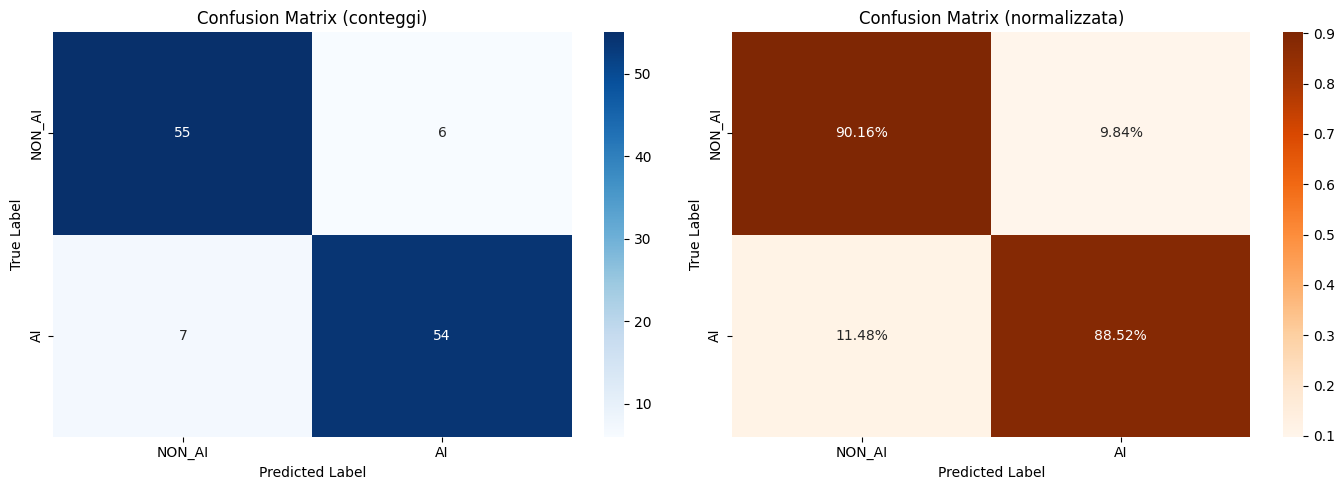

In [37]:
if result:
    y_true, y_pred, y_scores = result
    cm = confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix (conteggi)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NON_AI", "AI"], yticklabels=["NON_AI", "AI"],
                ax=axes[0])
    axes[0].set_title("Confusion Matrix (conteggi)")
    axes[0].set_ylabel("True Label")
    axes[0].set_xlabel("Predicted Label")
    
    # Confusion Matrix (normalizzata)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=["NON_AI", "AI"], yticklabels=["NON_AI", "AI"],
                ax=axes[1])
    axes[1].set_title("Confusion Matrix (normalizzata)")
    axes[1].set_ylabel("True Label")
    axes[1].set_xlabel("Predicted Label")
    
    plt.tight_layout()
    plt.show()

## Riepilogo Metriche (Bar Chart)

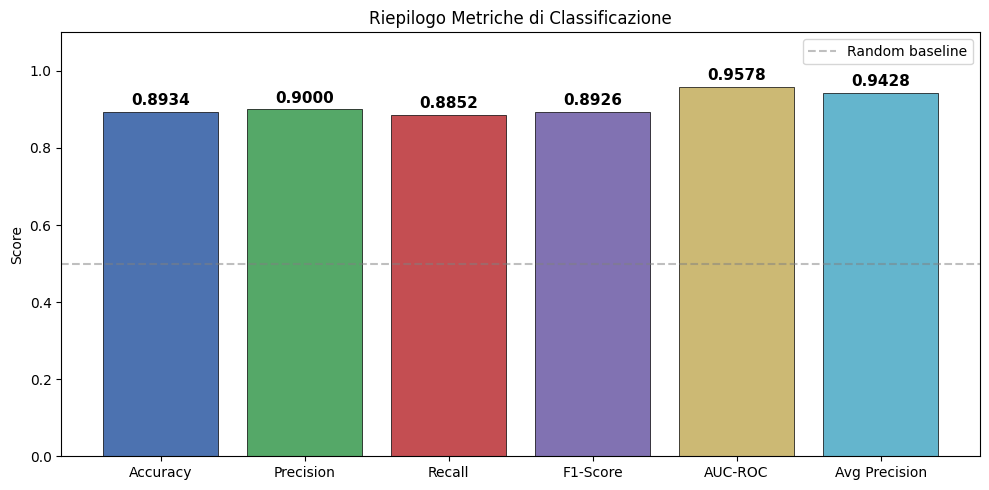

In [38]:
if result:
    y_true, y_pred, y_scores = result
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    try:
        auc = roc_auc_score(y_true, y_scores)
    except:
        auc = 0.0
    try:
        ap = average_precision_score(y_true, y_scores)
    except:
        ap = 0.0
    
    metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC", "Avg Precision"]
    metric_values = [acc, prec, rec, f1, auc, ap]
    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(metric_names, metric_values, color=colors, edgecolor='black', linewidth=0.5)
    
    # Aggiungi valori sopra le barre
    for bar, val in zip(bars, metric_values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{val:.4f}", ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Score")
    ax.set_title("Riepilogo Metriche di Classificazione")
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
    ax.legend()
    plt.tight_layout()
    plt.show()

## ROC Curve

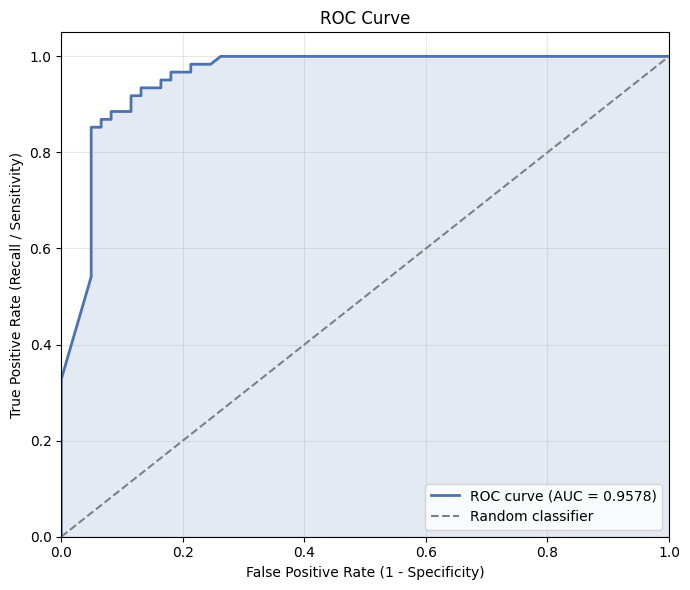

In [39]:
if result:
    y_true, y_pred, y_scores = result
    
    try:
        fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
        auc = roc_auc_score(y_true, y_scores)
    
        fig, ax = plt.subplots(figsize=(7, 6))
        ax.plot(fpr, tpr, color='#4C72B0', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
        ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random classifier')
        ax.fill_between(fpr, tpr, alpha=0.15, color='#4C72B0')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate (1 - Specificity)')
        ax.set_ylabel('True Positive Rate (Recall / Sensitivity)')
        ax.set_title('ROC Curve')
        ax.legend(loc='lower right')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Impossibile calcolare la ROC curve: {e}")

## Precision-Recall Curve

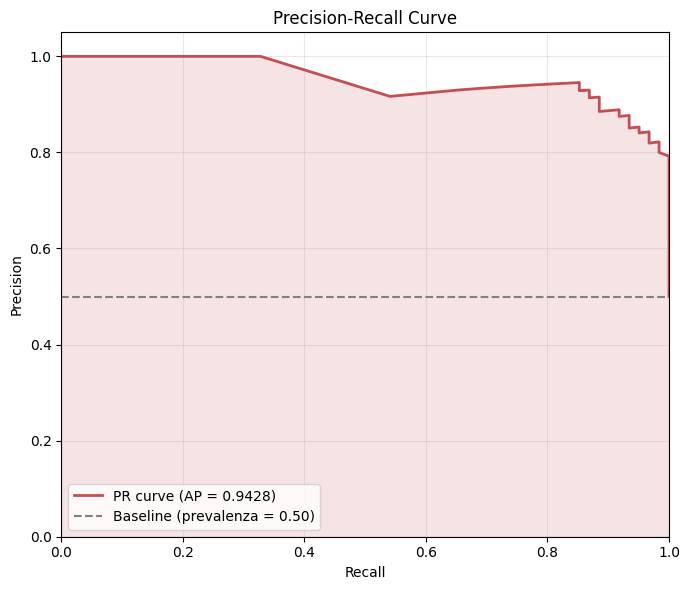

In [40]:
if result:
    y_true, y_pred, y_scores = result
    
    try:
        prec_curve, rec_curve, thresholds_pr = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)
    
        fig, ax = plt.subplots(figsize=(7, 6))
        ax.plot(rec_curve, prec_curve, color='#C44E52', lw=2, label=f'PR curve (AP = {ap:.4f})')
        ax.fill_between(rec_curve, prec_curve, alpha=0.15, color='#C44E52')
        
        # Baseline = prevalenza della classe positiva
        prevalence = sum(y_true) / len(y_true)
        ax.axhline(y=prevalence, color='gray', lw=1.5, linestyle='--', label=f'Baseline (prevalenza = {prevalence:.2f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend(loc='lower left')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Impossibile calcolare la PR curve: {e}")

## Distribuzione Score per Classe

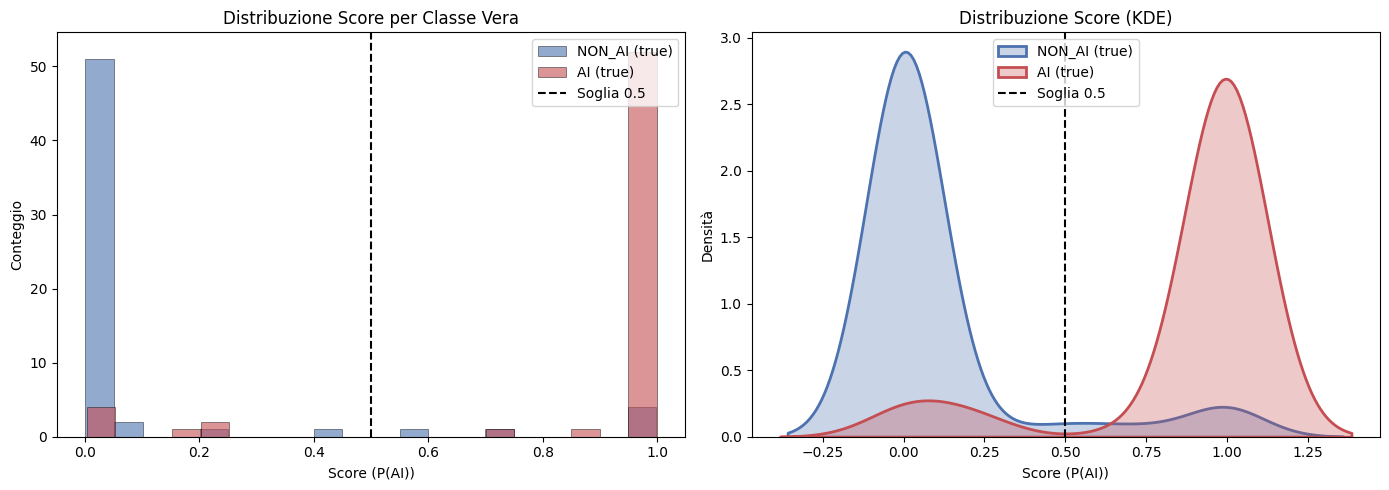

In [41]:
if result:
    y_true, y_pred, y_scores = result
    
    y_true_arr = np.array(y_true)
    y_scores_arr = np.array(y_scores)
    
    scores_ai = y_scores_arr[y_true_arr == 1]
    scores_non_ai = y_scores_arr[y_true_arr == 0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribuzione sovrapposta
    axes[0].hist(scores_non_ai, bins=20, alpha=0.6, color='#4C72B0', label='NON_AI (true)', edgecolor='black', linewidth=0.5)
    axes[0].hist(scores_ai, bins=20, alpha=0.6, color='#C44E52', label='AI (true)', edgecolor='black', linewidth=0.5)
    axes[0].axvline(x=0.5, color='black', linestyle='--', lw=1.5, label='Soglia 0.5')
    axes[0].set_xlabel('Score (P(AI))')
    axes[0].set_ylabel('Conteggio')
    axes[0].set_title('Distribuzione Score per Classe Vera')
    axes[0].legend()
    
    # KDE
    sns.kdeplot(scores_non_ai, ax=axes[1], color='#4C72B0', lw=2, label='NON_AI (true)', fill=True, alpha=0.3)
    sns.kdeplot(scores_ai, ax=axes[1], color='#C44E52', lw=2, label='AI (true)', fill=True, alpha=0.3)
    axes[1].axvline(x=0.5, color='black', linestyle='--', lw=1.5, label='Soglia 0.5')
    axes[1].set_xlabel('Score (P(AI))')
    axes[1].set_ylabel('Densità')
    axes[1].set_title('Distribuzione Score (KDE)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## Precision & Recall per Classe

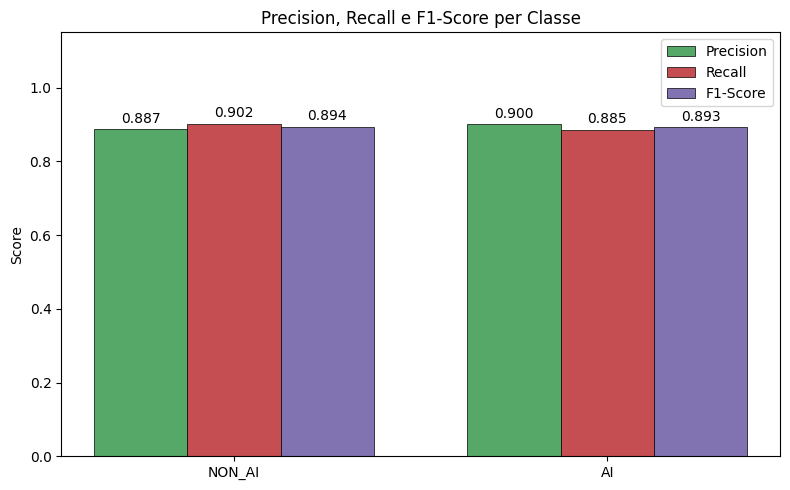

In [42]:
if result:
    y_true, y_pred, y_scores = result
    
    # Calcola precision e recall per ciascuna classe
    prec_per_class = precision_score(y_true, y_pred, average=None, labels=[0, 1])
    rec_per_class = recall_score(y_true, y_pred, average=None, labels=[0, 1])
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=[0, 1])
    
    class_names = ["NON_AI", "AI"]
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width, prec_per_class, width, label='Precision', color='#55A868', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, rec_per_class, width, label='Recall', color='#C44E52', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='#8172B2', edgecolor='black', linewidth=0.5)
    
    # Valori sopra le barre
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10)
    
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall e F1-Score per Classe')
    ax.legend()
    plt.tight_layout()
    plt.show()